**資料主題: Retail Price Optimization**

**資料來源**: https://www.kaggle.com/datasets/suddharshan/retail-price-optimization/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
from itertools import combinations
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

# 資料處理與探索資料

## 讀取資料與查看變數

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
rp = pd.read_csv('/content/retail_price.csv')
rp.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [ ]:
rp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

變數介紹:
product_id : 產品名稱\
product_category_name : 產品類別\
month_year : 日期(以月為單位)\
qty : 銷售數量\
unit_price : 物品單價\
total_price : 總金額(qty * unit_price) \
freight_price : 運費\
product_name_lenght : 產品名稱長度\
product_description_lenght : 產品敘述的長度\
product_photos_qty : 產品的照片數量\
product_weight_g : 產品的重量\
product_score  : 用戶對產品的評分\
customers : 此產品的需求量\
weekday : 工作日天數\
weekend : 假日天數\
holiday : 節日天數\
volume : 產品的大小\
comp_1、2、3 : 其他3個競爭對手對此產品的定價\
ps1、2、3 : 其他3個競爭對手的用戶對此產品的評分\
fp1、2、3 : 其他3個競爭對手的產品運費\
lag_price : 上個月的單價


可以知道總共有30個變數,676筆資料

In [ ]:
rp.describe()

,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,...,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,14.495562,1422.708728,20.682270,106.496800,48.720414,767.399408,1.994083,1847.498521,4.085503,81.028107,...,79.452054,4.159467,18.597610,92.930079,4.123521,18.620644,84.182642,4.002071,17.965007,107.399684
std,15.443421,1700.123100,10.081817,76.182972,9.420715,655.205015,1.420473,2274.808483,0.232021,62.055560,...,47.933358,0.121652,9.406537,49.481269,0.207189,6.424174,47.745789,0.233292,5.533256,76.974657
min,1.000000,19.900000,0.000000,19.900000,29.000000,100.000000,1.000000,100.000000,3.300000,1.000000,...,19.900000,3.700000,0.095439,19.900000,3.300000,4.410000,19.900000,3.500000,7.670000,19.850000
25%,4.000000,333.700000,14.761912,53.900000,40.000000,339.000000,1.000000,348.000000,3.900000,34.000000,...,49.910000,4.100000,13.826429,53.900000,4.100000,14.485000,53.785714,3.900000,15.042727,55.668750
50%,10.000000,807.890000,17.518472,89.900000,51.000000,501.000000,1.500000,950.000000,4.100000,62.000000,...,69.900000,4.200000,16.618984,89.990000,4.200000,16.811765,59.900000,4.000000,16.517110,89.900000
75%,18.000000,1887.322500,22.713558,129.990000,57.000000,903.000000,2.000000,1850.000000,4.200000,116.000000,...,104.256549,4.200000,19.732500,117.888889,4.200000,21.665238,99.990000,4.100000,19.447778,129.990000
max,122.000000,12095.000000,79.760000,364.000000,60.000000,3006.000000,8.000000,9750.000000,4.500000,339.000000,...,349.900000,4.500000,57.230000,349.900000,4.400000,57.230000,255.610000,4.400000,57.230000,364.000000


## 資料處理

處理未知變數與多餘的變數:

S:資料集沒有此變數的說明,所以不放入參考

month_year : 因為有年跟月這兩個變數了,所以也拿掉



In [7]:
rp.drop(['s','month_year'], axis=1, inplace=True)
rp.head()

,product_id,product_category_name,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,1,45.95,15.100000,45.95,39,161,2,350,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,3,137.85,12.933333,45.95,39,161,2,350,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,6,275.70,14.840000,45.95,39,161,2,350,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,4,183.80,14.287500,45.95,39,161,2,350,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,2,91.90,15.100000,45.95,39,161,2,350,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


處理NA值

In [ ]:
rp.isnull().sum()

product_id                    0
product_category_name         0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

## 查看變數關係

### Total prices

#### Total prices分佈

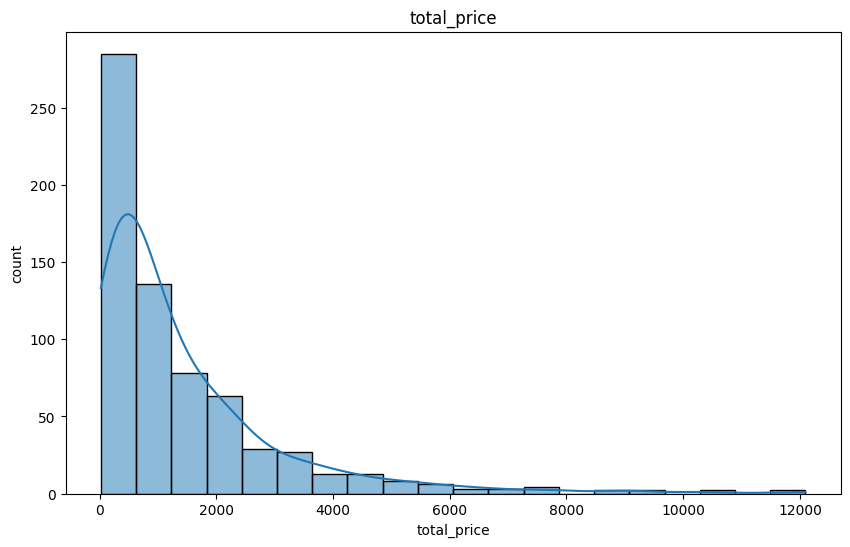

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rp['total_price'], bins=20, kde=True)
plt.title('total_price')
plt.xlabel('total_price')
plt.ylabel('count')
plt.show()

可以看出是一個明顯的右偏分佈,大部分物品每個月的總金額都不高

####Total prices vs month

In [ ]:
month_rp = rp.groupby('month')['total_price'].sum().reset_index()
fig = px.bar(month_rp, x='month', y='total_price', title='total_price vs month ')
fig.update_xaxes(categoryorder='category ascending', dtick=1)
fig.show()

除了9月10月較低外其他月份總金額比較平均

####Total_price vs holiday


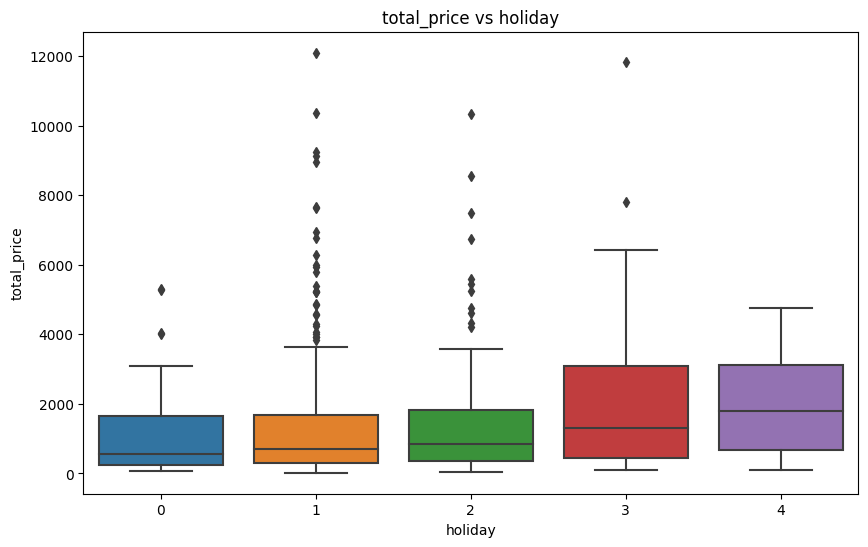

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='holiday', y="total_price", data=rp)
plt.title('total_price vs holiday')
plt.show()

能發現其實不管一個月有幾個節日對total price影響都不是很大,但在1天及2天的極端值比較多。

####Total_price vs category

In [ ]:
category_total_price = rp.groupby('product_category_name')['total_price'].sum().reset_index()
fig = px.bar(category_total_price, x='product_category_name', y='total_price',
             title='Total Price by Product Category',
             labels={'product_category_name': 'Product Category', 'total_price': 'Total Price'})

# 显示图表
fig.show()

可以發現 healthy_beauty跟watches_gifts這兩個種類的收入是最高的

####Total_price vs product_score

In [ ]:
score_rp = rp.groupby('product_score')['total_price'].sum().reset_index()
fig = px.bar(score_rp, x='product_score', y='total_price', title='total_price vs score ')
fig.show()

在評分4.1 4.2 4.3這三個評分的收益是最好的。

### Unit price

#### Unit price分佈

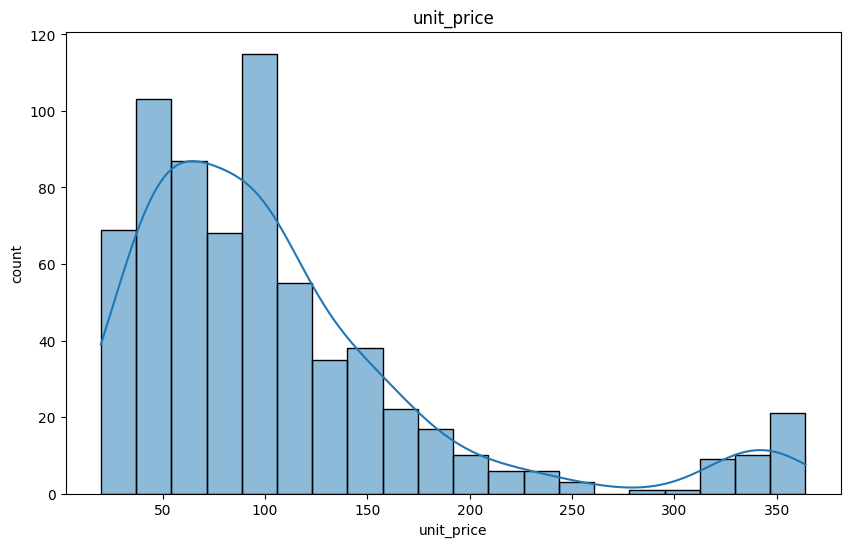

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rp['unit_price'], bins=20, kde=True)
plt.title('unit_price')
plt.xlabel('unit_price')
plt.ylabel('count')
plt.show()

大部分數據也是集中在左半邊

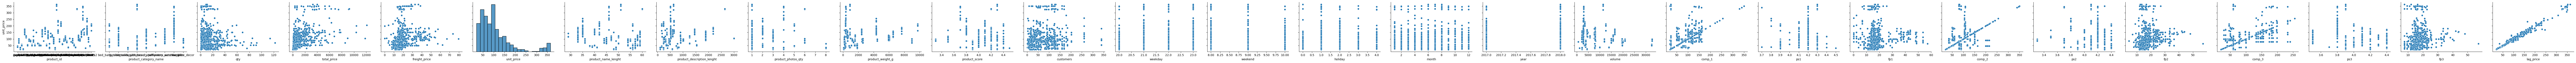

In [8]:
import seaborn as sns
import pandas as pd

sns.pairplot(rp, y_vars=['unit_price'], x_vars=rp.columns, height=3, aspect=1.5)
plt.show()

#### Unit_price vs freight_price

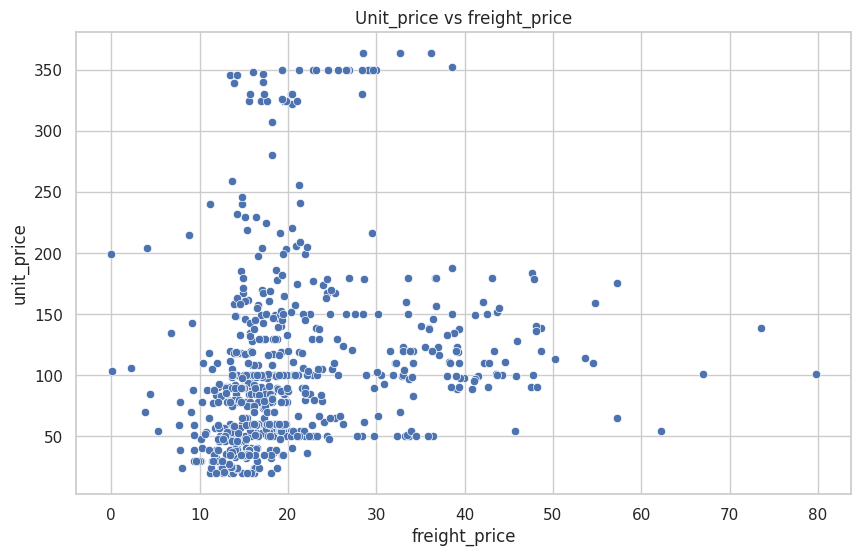

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x='freight_price', y='unit_price',data=rp)
plt.ylabel('unit_price')
plt.xlabel('freight_price')
plt.title('Unit_price vs freight_price')
plt.show()

可以看出大部分的單價不太會影響運費,運費在10到30之間是最多的

####Unit_price vs lag_price

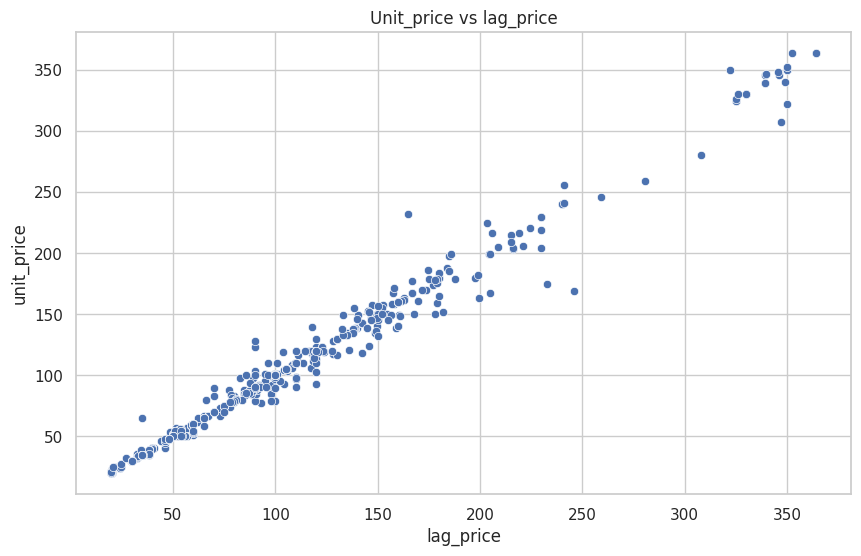

In [ ]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x='lag_price', y='unit_price',data=rp)
plt.ylabel('unit_price')
plt.xlabel('lag_price')
plt.title('Unit_price vs lag_price')
plt.show()

可以看出商品的單價蠻穩定的,短時間裡基本上不太會去改變

####Unit_price vs qty

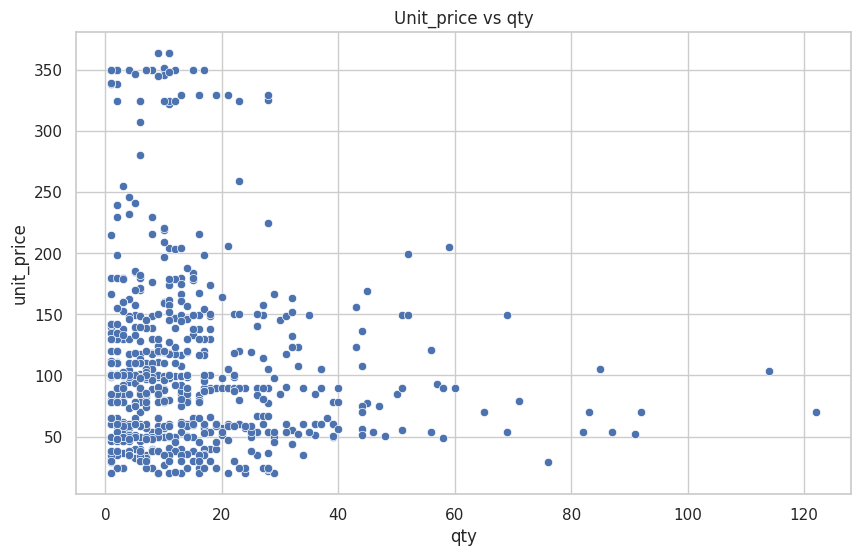

In [11]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x='qty', y='unit_price',data=rp)
plt.ylabel('unit_price')
plt.xlabel('qty')
plt.title('Unit_price vs qty')
plt.show()

單價不太受到賣出的數量影響,售出的數量都集中在0到30之間,

####Unit_price vs total_price

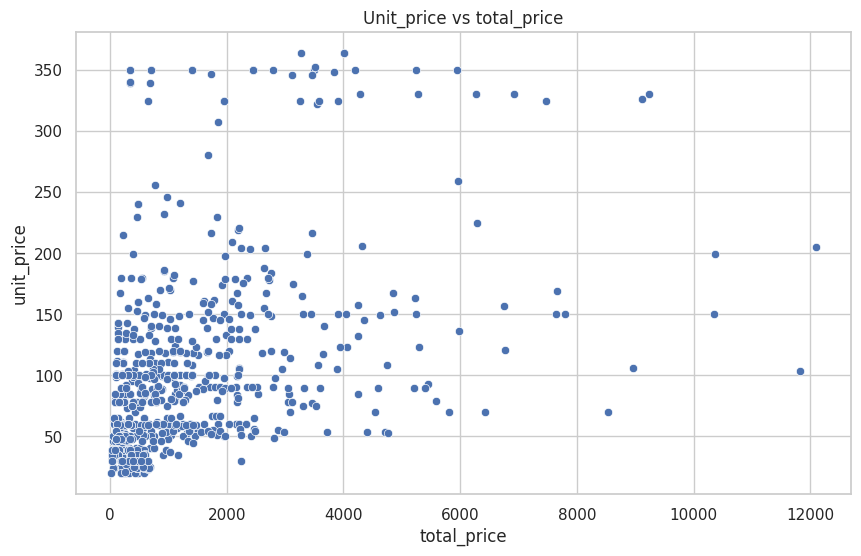

In [12]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.scatterplot(x='total_price', y='unit_price',data=rp)
plt.ylabel('unit_price')
plt.xlabel('total_price')
plt.title('Unit_price vs total_price')
plt.show()

####Unit_price vs year

In [13]:
fig = px.box(rp, x='year', y='unit_price',
             labels={'year': 'Year', 'unit_price': 'Unit Price'})
fig.show()

圖中可觀察到年份和單價似乎無太大關係。

####Unit_price vs month

In [14]:
fig = px.box(rp, x='month', y='unit_price',
             labels={'month': 'Month', 'unit_price': 'Unit Price'})
fig.show()

圖中可觀察到月份和單價似乎無太大關係。

####Unit_price vs product_category_name

In [18]:
fig = px.box(rp, x='product_category_name', y='unit_price',
             labels={'product_category_name': 'Product Category', 'unit_price': 'Unit Price'})
fig.show()

圖中可觀察到產品類別和單價可能有些關係。

####Unit_price vs product_score

In [17]:
fig = px.box(rp, x='product_score', y='unit_price',
             labels={'product_score': 'Product Score', 'unit_price': 'Unit Price'})
fig.show()

圖中可觀察到顧客評分和單價可能有些關係。

###所有變數熱力圖

<Axes: >

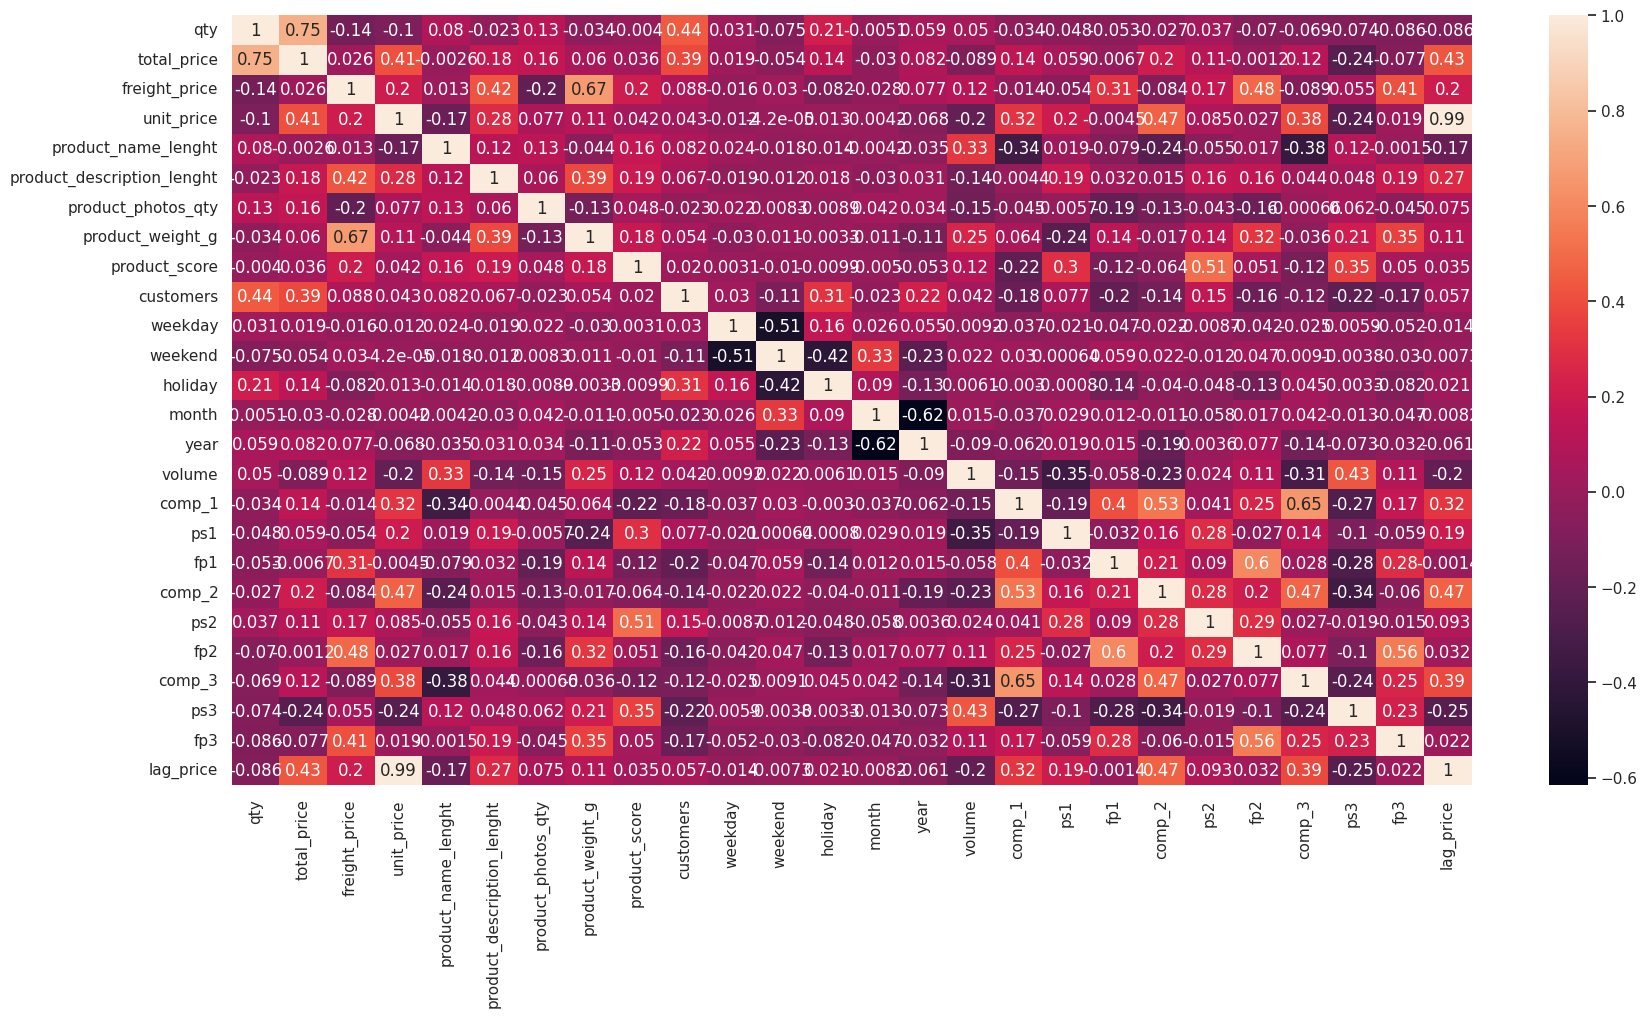

In [19]:
rp_h=rp.corr()
plt.figure(figsize=(20,10))
sns.heatmap(rp_h,annot=True)

#預測單價(unit price)

## 預測前資料處理

In [ ]:
comp = ['comp_1', 'comp_2', 'comp_3']
rp['comp_mean'] = rp[comp].mean(axis=1)
ps = ['ps1', 'ps2', 'ps3']
rp['ps_mean'] = rp[ps].mean(axis=1)
fp = ['fp1', 'fp2', 'fp3']
rp['fp_mean'] = rp[fp].mean(axis=1)
rp.drop(['comp_1', 'comp_2', 'comp_3','ps1', 'ps2', 'ps3','fp1', 'fp2', 'fp3'],axis=1, inplace=True)
rp.head()

,product_id,product_category_name,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,...,weekday,weekend,holiday,month,year,volume,lag_price,comp_mean,ps_mean,fp_mean
0,bed1,bed_bath_table,1,45.95,15.100000,45.95,39,161,2,350,...,23,8,1,5,2017,3800,45.90,116.950000,4.1,12.957299
1,bed1,bed_bath_table,3,137.85,12.933333,45.95,39,161,2,350,...,22,8,1,6,2017,3800,45.95,114.950000,4.1,16.341516
2,bed1,bed_bath_table,6,275.70,14.840000,45.95,39,161,2,350,...,21,10,1,7,2017,3800,45.95,113.616667,4.1,17.009922
3,bed1,bed_bath_table,4,183.80,14.287500,45.95,39,161,2,350,...,23,8,1,8,2017,3800,45.95,111.786601,4.1,16.119047
4,bed1,bed_bath_table,2,91.90,15.100000,45.95,39,161,2,350,...,21,9,1,9,2017,3800,45.95,99.749570,4.1,19.400403


###變數篩選

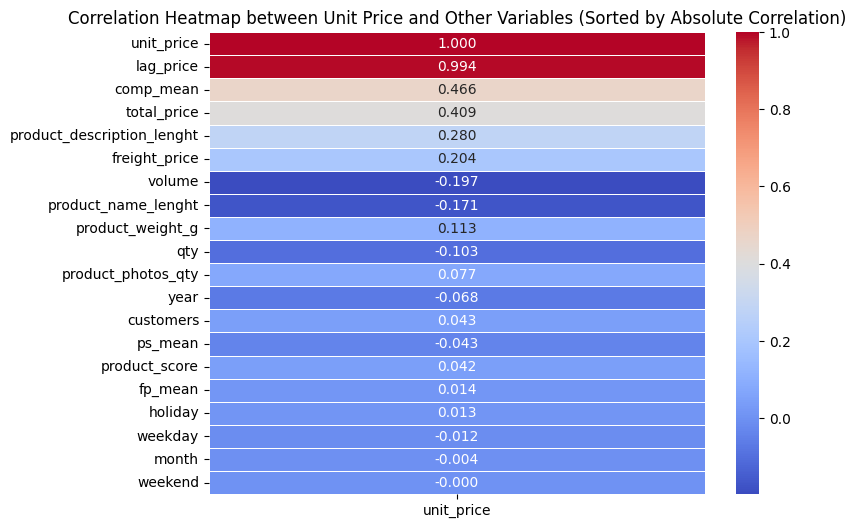

In [ ]:
h_new = rp.corr()
sorted_corr = h_new['unit_price'].abs().sort_values(ascending=False)
sorted_corr_matrix = h_new.loc[sorted_corr.index, ['unit_price']]
plt.figure(figsize=(8, 6))
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=.5)
plt.title('Correlation Heatmap between Unit Price and Other Variables (Sorted by Absolute Correlation)')
plt.show()

這邊我們就選取相關性取絕對值大於2的6個變數來做預測


###分割資料

In [ ]:
X = rp[['lag_price', 'comp_mean', 'total_price', 'product_description_lenght', 'freight_price', 'volume']]
y = rp['unit_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

### 共線性問題

In [ ]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                      Feature       VIF
0                   lag_price  4.957114
1                   comp_mean  4.464615
2                 total_price  2.088379
3  product_description_lenght  3.123164
4               freight_price  5.602019
5                      volume  2.156670


In [ ]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

                      Feature        VIF
0                   comp_mean   4.443830
1                 total_price   4.815511
2  product_description_lenght   3.541274
3               freight_price   9.434446
4                      volume   3.367886
5         product_name_lenght  12.641648
6            product_weight_g   3.536406
7                         qty   5.031389


#模型篩選

##放入lag price

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=2023)

我們會以MSE作為模型篩選的評分

#### linear regression

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_test_pred = linear.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")
print(f'R^2 : {r_2}')


Test MSE: 78.99773486466738
R^2 : 0.9860314242297328


In [ ]:
scores = cross_val_score(linear, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()

print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 59.73195223875511


用線性模型來看R^2 有0.988了,代表可以很好的解釋目標的變化

In [ ]:
coefficients = linear.coef_
intercept = linear.intercept_

# 输出每个特征对应的系数
for feature, coef in zip(X.columns, coefficients):
    print(f'{feature}: {coef}')

# 输出截距项
print(f'Intercept: {intercept}')

lag_price: 0.9914125152270336
comp_mean: 0.008319851049296476
total_price: -0.000920860627423806
product_description_lenght: 0.001028596978780439
freight_price: -0.02126312631023876
volume: 3.47806366091186e-05
Intercept: -0.06797111744585038


#### Ridge regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=0.01)
ridge.fit(X_train_scaled, y_train)
y_test_pred = ridge.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f'R^2 : {r_2}')

Test MSE: 2637.0931615753425
R^2 : 0.5337026345904228


In [ ]:
scores = cross_val_score(ridge, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()

print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 59.73195216089764


#### lasso regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
y_test_pred = lasso.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f'R^2 : {r_2}')

Test MSE: 78.9563646613325
R^2 : 0.986038739411882


In [ ]:
scores = cross_val_score(lasso, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()

print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 59.7315450171296


由三個線性模型來比較,三者的test MSE幾乎是一樣的,可能是因為普通線性模型原本就擬和數據,導致正則化的幫助不大

### Decision Tree

In [ ]:
param_grid = {
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}
tree = DecisionTreeRegressor(random_state=2023)
grid_search = GridSearchCV(tree, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")

最佳参数：{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [ ]:
tree_model = grid_search.best_estimator_
tree_model.fit(X_train,y_train)
y_test_pred = tree_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")


Test MSE: 77.04369441236186


In [ ]:
scores = cross_val_score(tree_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()
print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 76.58558980089974


In [ ]:
best_max_depth = 4
best_min_samples_leaf = 2
best_min_samples_split = 5
best_tree = DecisionTreeRegressor(max_depth=best_max_depth,
                  min_samples_leaf=best_min_samples_leaf,

                  min_samples_split=best_min_samples_split)
best_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=5)

In [ ]:
y_test_pred = best_tree.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

Test MSE: 95.76385225109048


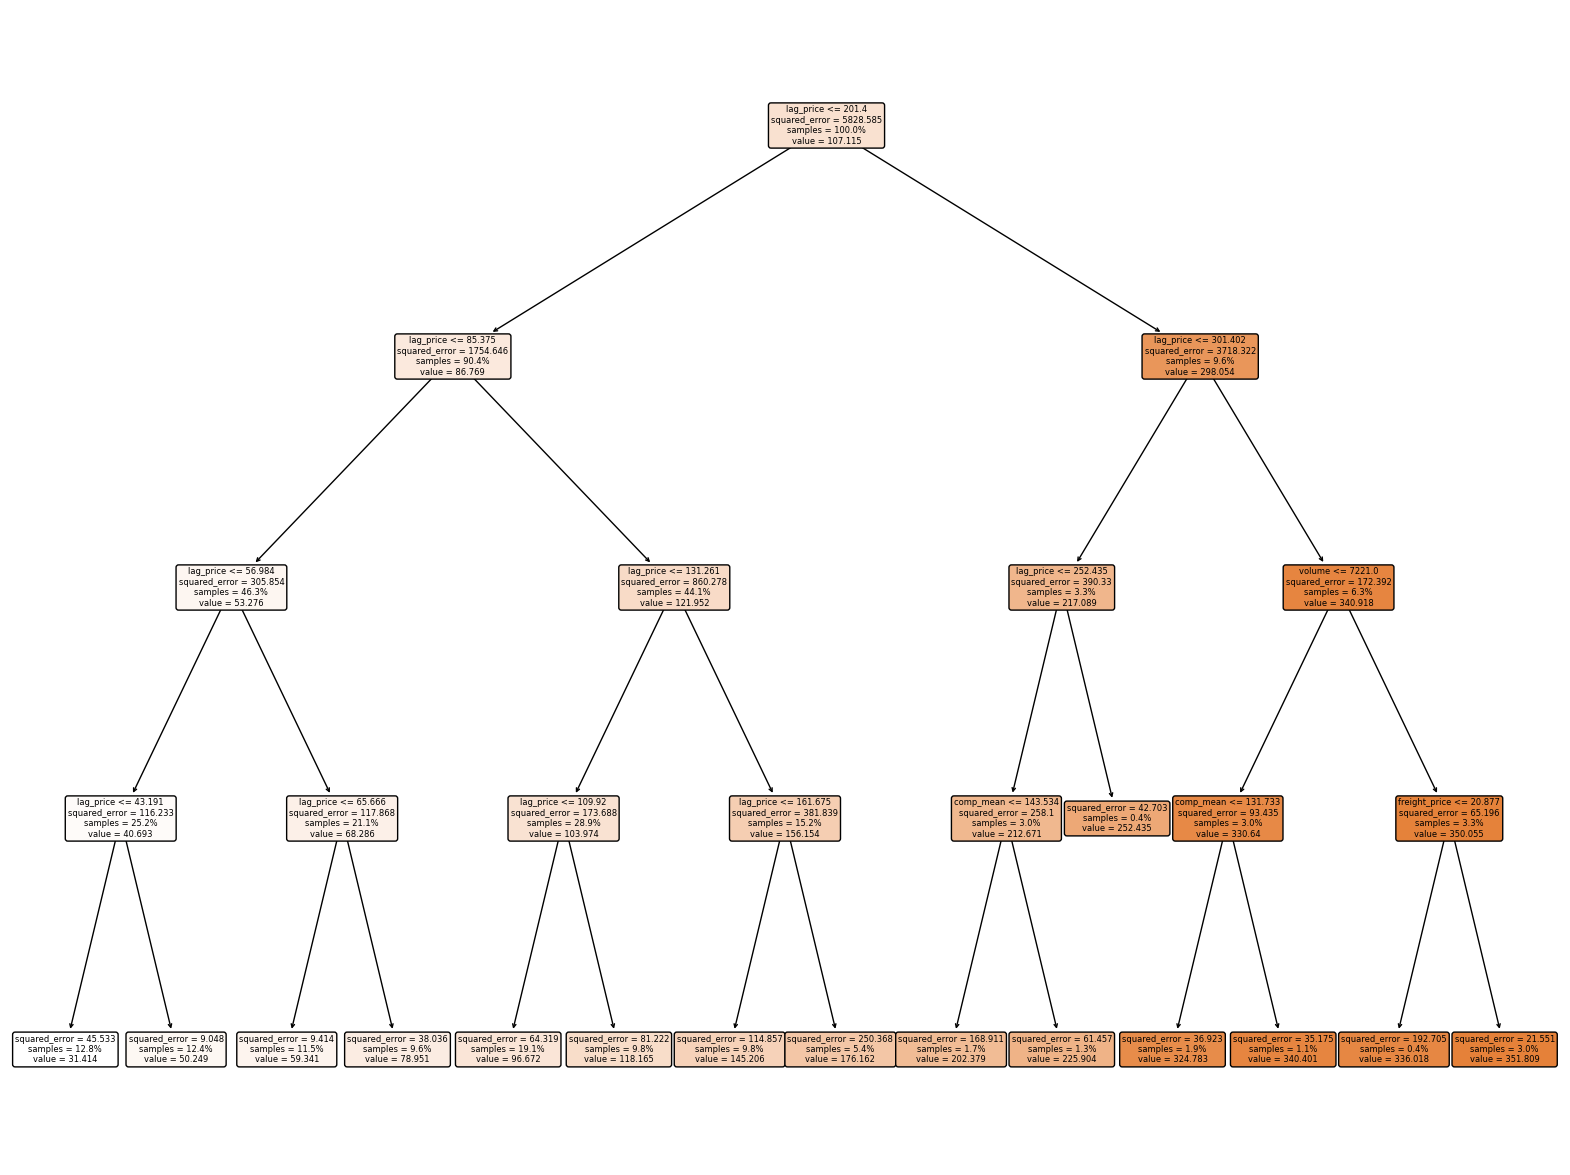

In [ ]:
plt.figure(figsize=(20, 15))
plot_tree(best_tree,
feature_names=X.columns,
rounded=True, # Rounded node edges
filled=True, # Adds color according to class
proportion=True,
fontsize=6);
plt.show()

### Randomforest

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestRegressor(random_state=2023)
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")


最佳参数：{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
rf_model = grid_search.best_estimator_
rf_model.fit(X_train,y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

Test MSE: 77.04369441236186


In [ ]:
scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()

print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 64.08786342392969


### XGBoost


In [ ]:
params_grid = {
        'n_estimators': [200,300,400,500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 5]
}
model=XGBRegressor(random_state=2023)
grid_search = GridSearchCV(model, params_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")


最佳参数：{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}


In [ ]:
XG_model = grid_search.best_estimator_
XG_model.fit(X_train,y_train)
y_test_pred = XG_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")



Test MSE: 68.92049967658838


In [ ]:
scores = cross_val_score(XG_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -scores
average_mse = mse_scores.mean()

print(f"交叉驗證的平均 MSE: {average_mse}")

交叉驗證的平均 MSE: 72.28758715512531


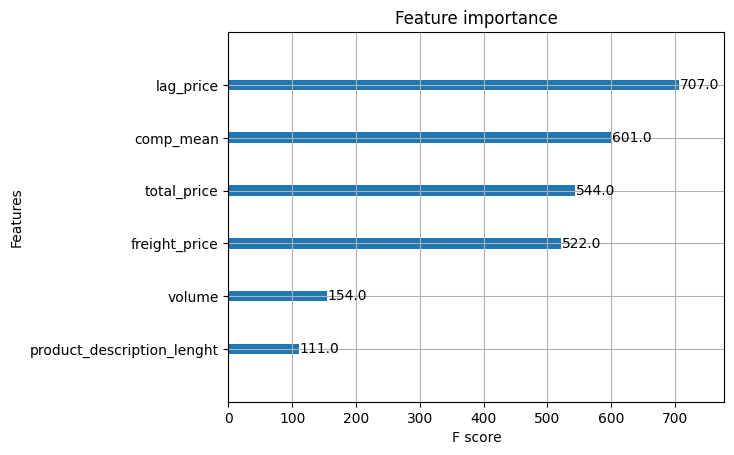

In [ ]:
plot_importance(XG_model)
plt.show()

##沒放入 lag price

In [ ]:
X = rp[['comp_mean', 'total_price', 'product_description_lenght', 'freight_price', 'volume', 'product_name_lenght','product_weight_g', 'qty' ]]
y = rp['unit_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

#### linear regression

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_test_pred = linear.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {mse_test}")
print(f'R^2 : {r_2}')


Test MSE: 1945.5833366877976
R^2 : 0.6559771200724891


### Ridge regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=0.01)
ridge.fit(X_train_scaled, y_train)
y_test_pred = ridge.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f'R^2 : {r_2}')

Test MSE: 1945.4686283447945
R^2 : 0.655997403086723


###  lasso regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
y_test_pred = lasso.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
r_2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f'R^2 : {r_2}')

Test MSE: 1945.3254837138495
R^2 : 0.6560227142760489


### Decision Tree

In [ ]:
param_grid = {
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}
tree = DecisionTreeRegressor(random_state=2023)
grid_search = GridSearchCV(tree, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")

最佳参数：{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
tree_model = grid_search.best_estimator_
tree_model.fit(X_train,y_train)
y_test_pred = tree_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
r_2 = r2_score(y_test, y_test_pred)
print(f'R^2 : {r_2}')

Test MSE: 1182.5794313585207
R^2 : 0.7908933665048756


### Randomforest

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 5, 7],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestRegressor(random_state=2023)
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")

最佳参数：{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
rf_model = grid_search.best_estimator_
rf_model.fit(X_train,y_train)
y_test_pred = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
r_2 = r2_score(y_test, y_test_pred)
print(f'R^2 : {r_2}')

Test MSE: 298.5825480408068
R^2 : 0.9472038919453514


### XGBoost

In [ ]:
params_grid = {
        'n_estimators': [200,300,400,500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 5]
}
model=XGBRegressor(random_state=2023)
grid_search = GridSearchCV(model, params_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
print(f"最佳参数：{best_params}")

最佳参数：{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}


In [ ]:
xg_model = grid_search.best_estimator_
xg_model.fit(X_train,y_train)
y_test_pred = xg_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
r_2 = r2_score(y_test, y_test_pred)
print(f'R^2 : {r_2}')

Test MSE: 160.82715994659713
Test MSE: 38.199957724462635
R^2 : 0.9715621419591398


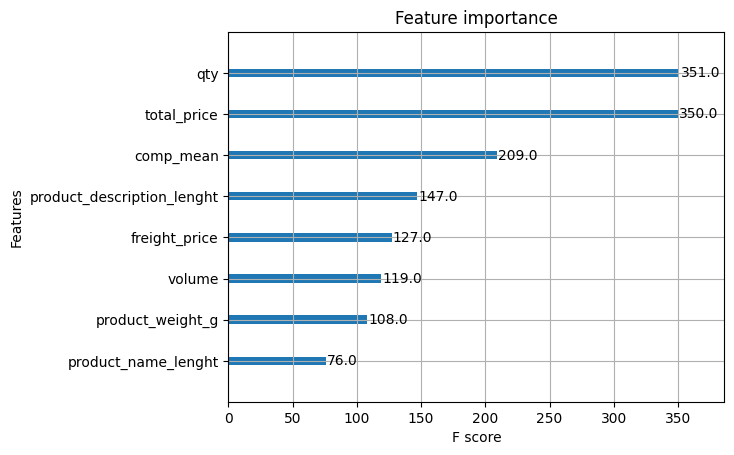

In [ ]:
plot_importance(xg_model)
plt.show()